In [4]:
import numpy as np
import pandas as pd
import statsrat as sr
from statsrat import latent_cause as lc
from statsrat.expr.predef.pvl_no_iti import latent_inhib as task
from plotnine import *

In [5]:
#model = lc.model(name = 'constant', kernel = lc.kernel.constant)
model = lc.model(name = 'power', kernel = lc.kernel.power)
print(model.pars)
save_plots = True

method = 'local_vb'
#method = 'particle'

prior_tau2_x = 1.0
prior_nu_x = 5.0
prior_tau2_y = 0.2
prior_nu_y = 1.5
alpha = 2.0
stick = 0.0
power = 1.0

par_vals = {'constant': [prior_tau2_x, prior_nu_x, prior_tau2_y, prior_nu_y, stick, alpha, 5.0],
            'power': [power, prior_tau2_x, prior_nu_x, prior_tau2_y, prior_nu_y, stick, alpha, 5.0]}

               min   max  default  \
power         0.00   5.0      1.0   
prior_tau2_x  0.01  10.0      1.0   
prior_nu_x    1.00  10.0      5.0   
prior_tau2_y  0.01  10.0      1.0   
prior_nu_y    1.00  10.0      5.0   
stick         0.00   5.0      1.0   
alpha         0.00  15.0      1.0   
resp_scale    0.00  10.0      1.0   

                                                    description  
power         decay rate for power law SCRP; higher -> favor...  
prior_tau2_x                 prior hyperparameter for eta for x  
prior_nu_x                   prior hyperparameter for eta for x  
prior_tau2_y                 prior hyperparameter for eta for y  
prior_nu_y                   prior hyperparameter for eta for y  
stick                                  stickiness for CRP prior  
alpha         concentration parameter; higher -> tend to inf...  
resp_scale           scales softmax/logistic response functions  


latent inhibition 

[0 0 0 0 0 1 1 1 1 1 0 0]
ex  ctx.cs
z         
0        7
1        5


/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.0 x 4.0 in image.
/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/latent_cause_latent_inhib_b_power.jpeg
/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.0 x 4.0 in image.
/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/latent_cause_latent_inhib_r_power.jpeg


0.10039750991355834
       schedule     trial_name u_name  mean_resp
0       control  cs -> nothing     us   0.984218
0  experimental  cs -> nothing     us   0.883820


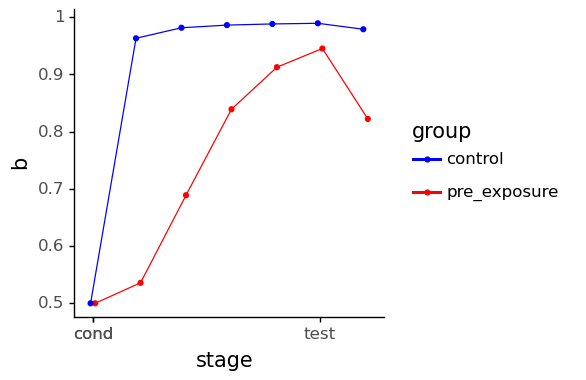

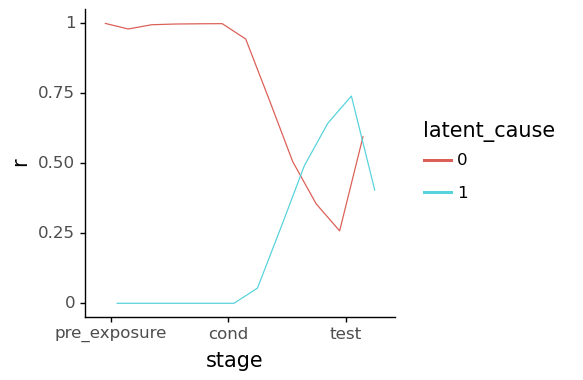

In [6]:
print('latent inhibition \n')

trials_exp = task.make_trials('experimental')
trials_ctl = task.make_trials('control')
sel = [{'t': trials_exp['stage_name'].isin(['cond', 'test'])}, None]

if method == 'particle':
    ds_exp = model.particle_filter(trials_exp, par_vals[model.name], n_p = 100)
    ds_ctl = model.particle_filter(trials_ctl, par_vals[model.name], n_p = 100)
    #sr.multi_plot([ds_exp, ds_ctl], var = 'b', only_main = True, sel = sel).draw()
    #sr.multi_plot([ds_exp, ds_ctl], var = 'mean_N', sel = sel).draw()
else:
    ds_exp = model.simulate(trials_exp, par_vals[model.name])
    ds_ctl = model.simulate(trials_ctl, par_vals[model.name])
    #sr.multi_plot([ds_exp, ds_ctl], var = 'b', only_main = True, sel = sel, dodge_width = 0.1).draw()
    #sr.multi_plot([ds_exp, ds_ctl], var = 'N', sel = sel, dodge_width = 0.1).draw()
    #sr.multi_plot([ds_exp, ds_ctl], var = 'phi_x', sel = sel, dodge_width = 0.1, schedule_facet = True).draw()
    df = ds_exp['z'].to_dataframe()
    table = pd.crosstab(df['z'], df['ex'])
    print(ds_exp['z'].values)
    print(table)
    
plot_b = sr.multi_plot([ds_exp, ds_ctl],
                        var = 'b',
                        draw_points = True,
                        dodge_width = 0.2,
                        rename_coords = {'schedule': 'group'},
                        rename_schedules = {'control': 'control', 'experimental': 'pre_exposure'},
                        sel = [{'t': ds_exp['stage_name'].isin(['cond', 'extinction', 'test'])}, None])
plot_b += scale_color_manual(values = {'pre_exposure': 'red', 'control': 'blue'})
plot_b.draw()
if save_plots:
    plot_b.save(filename = 'plots/latent_cause_latent_inhib_b_' + model.name + '.jpeg', dpi = 500)

plot_r = sr.learn_plot(ds_exp,
                       var = 'phi_x',
                       rename_coords = {'z_name': 'latent_cause'},
                       sel = {'z_name': ['0', '1']})
plot_r += ylab('r')
plot_r.draw()
if save_plots:
    plot_r.save(filename = 'plots/latent_cause_latent_inhib_r_' + model.name + '.jpeg', dpi = 500)
    
oat_name = list(task.oats.keys())[0]
print(task.oats[oat_name].compute_total({'experimental': ds_exp, 'control': ds_ctl}))
print(task.oats[oat_name].mean_resp({'experimental': ds_exp, 'control': ds_ctl}))